In [2]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict, Counter
from sklearn.decomposition import TruncatedSVD
import itertools
from scipy.stats import linregress
import plotly_express as px
import torch.nn.functional as F
import pickle
import math
import seaborn as sns

In [3]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def get_feature_activations(sae, steps):
    feature_activations = []
    for _, s in enumerate(steps):
        active_feature_ids = s["active_feature_ids"]
        active_feature_acts = s["active_feature_acts"]
        feature_acts = torch.zeros(sae.W_enc.shape[1])
        feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
        feature_activations.append(feature_acts)
    return torch.stack(feature_activations)

In [4]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [5]:
perturbation_layer = "blocks.1.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
sae.eval()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


## Feature interpolations

In [5]:
def interpolate_features(steps):
    start_active_ids = steps[0]["active_feature_ids"]
    start_active_feat_acts = steps[0]["active_feature_acts"]

    end_active_ids = steps[-1]["active_feature_ids"]
    end_active_feat_acts = steps[-1]["active_feature_acts"]

    all_active_feature_ids = list(set(start_active_ids + end_active_ids))
    all_active_feats = {k: {"start": 0, "end": 0} for k in all_active_feature_ids}

    for f_id, f_act in zip(start_active_ids, start_active_feat_acts):
        all_active_feats[f_id]["start"] = f_act

    for f_id, f_act in zip(end_active_ids, end_active_feat_acts):
        all_active_feats[f_id]["end"] = f_act

    interpolated_feature_acts = []

    for i in range(len(steps)):
        f_act = torch.zeros(sae.W_enc.shape[1])
        for f_id in all_active_feature_ids:
            f_range = all_active_feats[f_id]
            step_size = (f_range["end"] - f_range["start"]) / 100
            feat_step_act = f_range["start"] + (step_size * i)
            f_act[f_id] = feat_step_act
        interpolated_feature_acts.append(f_act)
    interpolated_feature_acts = torch.stack(interpolated_feature_acts)
    return interpolated_feature_acts

In [120]:
cos_sim_sae_enc_acts_and_acts = []
cos_sim_interp_acts_and_acts = []

l2_sae_enc_acts_and_acts = []
l2_interp_acts_and_acts = []

n_examples = 5000
idxs = random.sample(range(len(metadata)), n_examples)

for idx in idxs:
    steps = metadata[idx]["steps_metadata"]
    feature_acts = get_feature_activations(sae, steps)
    acts = torch.tensor(activations[idx])

    start_active_ids = steps[0]["active_feature_ids"]
    start_active_feat_acts = steps[0]["active_feature_acts"]

    end_active_ids = steps[-1]["active_feature_ids"]
    end_active_feat_acts = steps[-1]["active_feature_acts"]

    all_active_feature_ids = list(set(start_active_ids + end_active_ids))
    all_active_feats = {k: {"start": 0, "end": 0} for k in all_active_feature_ids}

    for f_id, f_act in zip(start_active_ids, start_active_feat_acts):
        all_active_feats[f_id]["start"] = f_act

    for f_id, f_act in zip(end_active_ids, end_active_feat_acts):
        all_active_feats[f_id]["end"] = f_act

    interpolated_feature_acts = []

    for i in range(100):
        f_act = torch.zeros(sae.W_enc.shape[1])
        for f_id in all_active_feature_ids:
            f_range = all_active_feats[f_id]
            step_size = (f_range["end"] - f_range["start"]) / 100
            feat_step_act = f_range["start"] + (step_size * i)
            f_act[f_id] = feat_step_act
        interpolated_feature_acts.append(f_act)
    interpolated_feature_acts = torch.stack(interpolated_feature_acts)

    decoded_orig_feat_acts = sae.decode(feature_acts)
    decoded_interpolated_feat_acts = sae.decode(interpolated_feature_acts)

    sim = F.cosine_similarity(decoded_orig_feat_acts, acts).mean().item()
    cos_sim_sae_enc_acts_and_acts.append(sim)

    sim = F.cosine_similarity(decoded_interpolated_feat_acts, acts).mean().item()
    cos_sim_interp_acts_and_acts.append(sim)

    l2_score = torch.norm(acts - decoded_orig_feat_acts, dim=1, p=2).sum().item()
    l2_sae_enc_acts_and_acts.append(l2_score)

    l2_score = (
        torch.norm(acts - decoded_interpolated_feat_acts, dim=1, p=2).sum().item()
    )
    l2_interp_acts_and_acts.append(l2_score)

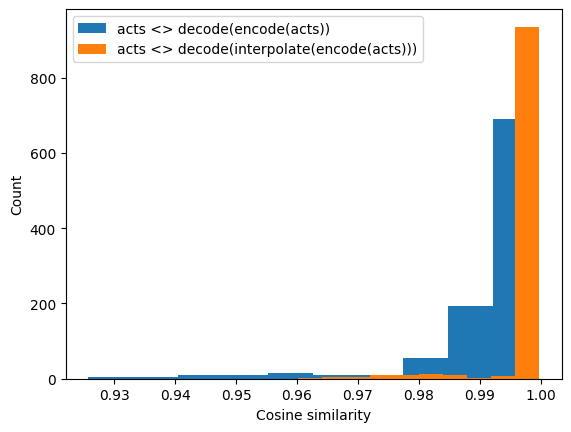

In [118]:
plt.hist(cos_sim_sae_enc_acts_and_acts, label="acts <> decode(encode(acts))")
plt.hist(
    cos_sim_interp_acts_and_acts, label="acts <> decode(interpolate(encode(acts)))"
)
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.legend()
plt.show()

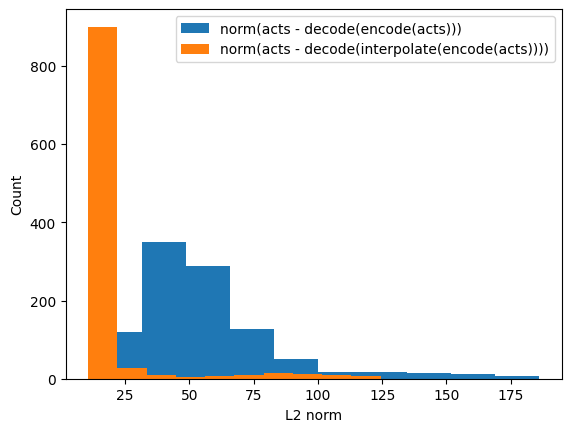

In [119]:
plt.hist(l2_sae_enc_acts_and_acts, label="norm(acts - decode(encode(acts)))")
plt.hist(
    l2_interp_acts_and_acts, label="norm(acts - decode(interpolate(encode(acts))))"
)
plt.xlabel("L2 norm")
plt.ylabel("Count")
plt.legend()
plt.show()

## Illustration line plots for L2 and KL Div

In [6]:
ticks_fontsize = 14
label_fontsize = 18
title_fontsize = 20
legend_fontsize = 14

In [11]:
filename = f"replications/results_1000_absolute.pkl"

with open(filename, "rb") as fr:
    results = pickle.load(fr)

#### L2

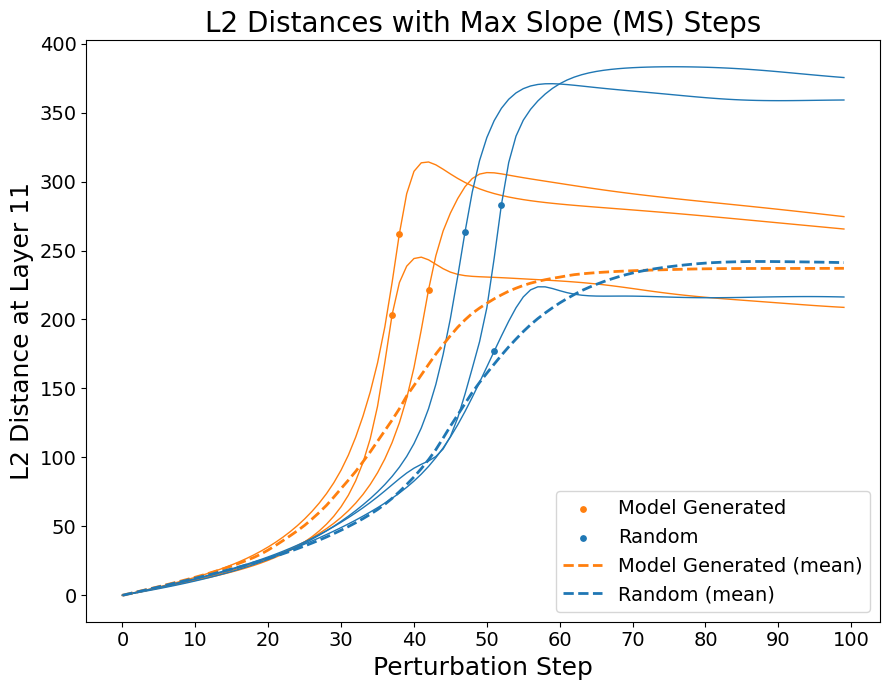

In [12]:
# Create the plot with a larger figure size
plt.figure(figsize=(9, 7))  # width, height

idxs = [1, 3, 4]
random_idxs = [0, 1, 2]

for i, idx in enumerate(idxs):
    label = i == 0
    pert_l2_dists = results["l2"]["other"][idx]
    l2_ms = results["l2_ms"]["other"][idx]

    # Plot the main line
    plt.plot(pert_l2_dists, linewidth=1, color="tab:orange")

    ms_label = "Model Generated" if label else None
    plt.scatter(
        l2_ms,
        pert_l2_dists[l2_ms],
        color="tab:orange",
        s=15,
        zorder=3,
        label=ms_label,
        marker="o",
    )

for i, idx in enumerate(random_idxs):
    label = i == 0
    pert_l2_dists = results["l2"]["random"][idx]
    l2_ms = results["l2_ms"]["random"][idx]

    # Plot the main line
    plt.plot(pert_l2_dists, linewidth=1, color="tab:blue")

    ms_label = "Random" if label else None
    plt.scatter(
        l2_ms,
        pert_l2_dists[l2_ms],
        color="tab:blue",
        s=15,
        zorder=3,
        label=ms_label,
        marker="o",
    )

l2_other_mean = torch.stack(results["l2"]["other"]).mean(dim=0)
plt.plot(
    l2_other_mean,
    linewidth=2,
    color="tab:orange",
    linestyle="dashed",
    label="Model Generated (mean)",
)


l2_other_mean = torch.stack(results["l2"]["random"]).mean(dim=0)
plt.plot(
    l2_other_mean,
    linewidth=2,
    color="tab:blue",
    linestyle="dashed",
    label="Random (mean)",
)


# Customize the plot
plt.title("L2 Distances with Max Slope (MS) Steps", fontsize=title_fontsize)
plt.xlabel("Perturbation Step", fontsize=label_fontsize)
plt.ylabel("L2 Distance at Layer 11", fontsize=label_fontsize)
plt.legend(loc="lower right", fontsize=legend_fontsize)

plt.xticks(np.arange(0, 101, 10), fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)

# Tight layout to use space efficiently
plt.tight_layout()

# Show the plot
plt.show()

#### KL Div

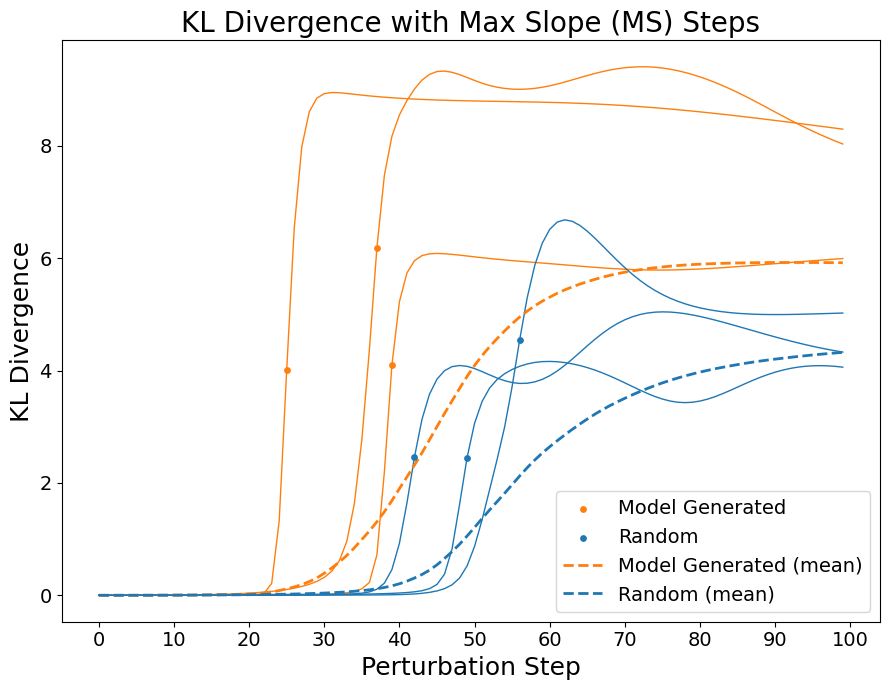

In [13]:
# Create the plot with a larger figure size
plt.figure(figsize=(9, 7))  # width, height

idxs = [3, 6, 15]
random_idxs = [0, 1, 9]

for i, idx in enumerate(idxs):
    label = i == 0
    pert_kl_div_dists = results["kl_div"]["other"][idx]
    kl_div_ms = results["kl_div_ms"]["other"][idx]

    # Plot the main line
    plt.plot(pert_kl_div_dists, linewidth=1, color="tab:orange")

    ms_label = "Model Generated" if label else None
    plt.scatter(
        kl_div_ms,
        pert_kl_div_dists[kl_div_ms],
        color="tab:orange",
        s=15,
        zorder=3,
        label=ms_label,
        marker="o",
    )

for i, idx in enumerate(random_idxs):
    label = i == 0
    pert_kl_div_dists = results["kl_div"]["random"][idx]
    kl_div_ms = results["kl_div_ms"]["random"][idx]

    # Plot the main line
    plt.plot(pert_kl_div_dists, linewidth=1, color="tab:blue")

    ms_label = "Random" if label else None
    plt.scatter(
        kl_div_ms,
        pert_kl_div_dists[kl_div_ms],
        color="tab:blue",
        s=15,
        zorder=3,
        label=ms_label,
        marker="o",
    )

kl_div_other_mean = torch.stack(results["kl_div"]["other"]).mean(dim=0)
plt.plot(
    kl_div_other_mean,
    linewidth=2,
    color="tab:orange",
    linestyle="dashed",
    label="Model Generated (mean)",
)


kl_div_other_mean = torch.stack(results["kl_div"]["random"]).mean(dim=0)
plt.plot(
    kl_div_other_mean,
    linewidth=2,
    color="tab:blue",
    linestyle="dashed",
    label="Random (mean)",
)


# Customize the plot
plt.title("KL Divergence with Max Slope (MS) Steps", fontsize=title_fontsize)
plt.xlabel("Perturbation Step", fontsize=label_fontsize)
plt.ylabel("KL Divergence", fontsize=label_fontsize)
plt.legend(loc="upper left", fontsize=legend_fontsize)

plt.xticks(np.arange(0, 101, 10), fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)

# Tight layout to use space efficiently
plt.tight_layout()
plt.legend(fontsize=legend_fontsize)

# Show the plot
plt.show()

## Feature activations distribution

In [5]:
import numpy as np
import torch
from sklearn.covariance import EmpiricalCovariance
from torch.distributions import MultivariateNormal
from sklearn.decomposition import PCA
import numpy as np
from scipy import stats
from scipy.stats import wasserstein_distance
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KernelDensity

In [6]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def generate_mean_cov(data, cov_method="full"):
    """
    Generate mean and covariance matrix for MultivariateNormal distribution.

    Args:
    data (numpy.ndarray): Input data of shape (n_samples, n_features)
    cov_method (str): Method to compute covariance. Options:
                      'full' - Full covariance matrix
                      'diag' - Diagonal covariance matrix
                      'sparse' - Sparse covariance matrix

    Returns:
    tuple: (data_mean, data_cov) as torch tensors
    """
    # Compute mean
    data_mean = torch.mean(data, dim=0)

    # Compute covariance
    if cov_method == "full":
        # Full covariance matrix
        data_cov = np.cov(data, rowvar=False)
    elif cov_method == "diag":
        # Diagonal covariance matrix
        data_cov = np.diag(np.var(data, axis=0))
    elif cov_method == "sparse":
        # Sparse covariance matrix
        ec = EmpiricalCovariance(assume_centered=False)
        ec.fit(data)
        data_cov = ec.covariance_
    else:
        raise ValueError("Invalid cov_method. Choose 'full', 'diag', or 'sparse'.")

    # Convert to torch tensors
    data_cov = torch.tensor(data_cov, dtype=torch.float32)

    return data_mean, data_cov


def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))


def evaluate_samples(original_data, generated_samples):
    results = {}

    # 1. Statistical Moments
    moment_functions = {
        "mean": np.mean,
        "std": np.std,
    }

    for moment, func in moment_functions.items():
        orig_moment = func(original_data, axis=0)
        gen_moment = func(generated_samples, axis=0)
        results[f"{moment}_mse"] = mean_squared_error(orig_moment, gen_moment)

    # 2. Wasserstein Distance
    results["wasserstein"] = np.mean(
        [
            wasserstein_distance(original_data[:, i], generated_samples[:, i])
            for i in range(original_data.shape[1])
        ]
    )

    # 3. KL Divergence (using KDE for estimation)
    kde_orig = KernelDensity().fit(original_data)
    kde_gen = KernelDensity().fit(generated_samples)

    log_dens_orig = kde_orig.score_samples(original_data)
    log_dens_gen = kde_gen.score_samples(original_data)

    results["kl_divergence"] = kl_divergence(
        np.exp(log_dens_orig), np.exp(log_dens_gen)
    )

    # 4. Sparsity
    orig_sparsity = np.mean(original_data == 0)
    gen_sparsity = np.mean(generated_samples == 0)
    results["sparsity_diff"] = abs(orig_sparsity - gen_sparsity)

    return results

In [7]:
metadata, activations = [], []

pert_type = "other_act"
n_files = 100

for path in sorted(glob(f"observations_layer1/metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob(f"observations_layer1/acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [8]:
activations.shape

(32000, 100, 768)

In [46]:
all_feature_acts = []

for m in metadata[:10_000]:
    feature_acts = torch.zeros(sae.W_dec.shape[0])
    active_feature_ids = m["steps_metadata"][0]["active_feature_ids"]
    active_feature_acts = m["steps_metadata"][0]["active_feature_acts"]
    feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
    all_feature_acts.append(feature_acts)

all_feature_acts = torch.stack(all_feature_acts)

In [47]:
all_feature_acts.shape

torch.Size([10000, 24576])

In [48]:
pca = PCA(n_components=0.95)  # Capture 95% of variance
transformed_data = torch.tensor(pca.fit_transform(all_feature_acts))

# Sample in reduced space
distrib = MultivariateNormal(
    torch.mean(transformed_data, dim=0), torch.cov(transformed_data.T)
)
samples = distrib.sample([10])

# Transform back to original space
original_space_samples = pca.inverse_transform(samples)

In [37]:
samples.shape

torch.Size([10, 551])

In [40]:
eval_results = evaluate_samples(
    all_feature_acts.numpy(), original_space_samples.numpy()
)
print(eval_results)

{'mean_mse': 0.002336642129205098, 'std_mse': 0.0022766319086058163, 'wasserstein': 0.02352722515224498, 'kl_divergence': 0.0, 'sparsity_diff': 0.1835206298828126}


/tmp/ipykernel_4891/153261314.py:50: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


## Graph of feature interactions

In [1]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data

In [8]:
metadata, activations = [], []

n_files = 100

for path in sorted(glob(f"observations_layer1/metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob(f"observations_layer1/acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [9]:
all_active_feature_ids = []
all_active_feature_acts = []
num_features = sae.W_dec.shape[0]

for m in metadata:
    feature_acts = torch.zeros(sae.W_dec.shape[0])
    active_feature_ids = m["steps_metadata"][0]["active_feature_ids"]
    active_feature_acts = m["steps_metadata"][0]["active_feature_acts"]
    all_active_feature_ids.append(active_feature_ids)
    all_active_feature_acts.append(active_feature_acts)

    active_feature_ids = m["steps_metadata"][-1]["active_feature_ids"]
    active_feature_acts = m["steps_metadata"][-1]["active_feature_acts"]
    all_active_feature_ids.append(active_feature_ids)
    all_active_feature_acts.append(active_feature_acts)

In [10]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import cg

# Assuming all_active_feature_ids is a list of lists
# Each sublist corresponds to an activation and contains indices of active features


# Step 1: Build the Co-occurrence Matrix
def build_co_occurrence_matrix(all_active_feature_ids, num_features):
    # Initialize an empty sparse matrix in LIL format for efficient construction
    co_occurrence = lil_matrix((num_features, num_features), dtype=np.int32)

    # Iterate over all activations
    for feature_ids in all_active_feature_ids:
        # Create combinations of feature indices
        for i in range(len(feature_ids)):
            for j in range(i + 1, len(feature_ids)):
                idx_i = feature_ids[i]
                idx_j = feature_ids[j]
                # Increment the co-occurrence count for the pair
                co_occurrence[idx_i, idx_j] += 1
                co_occurrence[idx_j, idx_i] += 1  # Symmetric matrix

    # Convert to CSR format for efficient arithmetic and matrix operations
    co_occurrence_csr = co_occurrence.tocsr()
    return co_occurrence_csr

In [11]:
# Build the co-occurrence matrix
co_occurrence_matrix = build_co_occurrence_matrix(all_active_feature_ids, num_features)

In [12]:
# Step 2: Compute the Graph Laplacian
def compute_graph_laplacian(co_occurrence_matrix):
    # Compute the Laplacian matrix
    laplacian_matrix = laplacian(co_occurrence_matrix, normed=False)
    return laplacian_matrix


laplacian_matrix = compute_graph_laplacian(co_occurrence_matrix)

In [53]:
from scipy.sparse import save_npz

# Assuming co_occurrence_matrix is your sparse matrix (e.g., in CSR format)
save_npz("replications/co_occurrence_matrix.npz", co_occurrence_matrix)

In [34]:
import networkx as nx
import numpy as np
from collections import defaultdict


def create_feature_graph(
    active_feature_ids,
    active_feature_acts,
    num_features,
    threshold=0.0,
    weight_by_activation=False,
    normalize_weights=True,
):
    """
    Create a graph of feature relationships based on co-activation.

    Args:
    active_feature_ids (list of lists): List of active feature IDs for each sample
    active_feature_acts (list of lists): List of activation strengths for each sample
    num_features (int): Total number of features
    threshold (float): Minimum weight for an edge to be included in the graph
    weight_by_activation (bool): If True, weight edges by the product of feature activations
    normalize_weights (bool): If True, normalize edge weights by the number of samples

    Returns:
    networkx.Graph: Graph of feature relationships
    dict: Average activation strength for each feature
    dict: Edge weights before thresholding
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_features))

    edge_weights = defaultdict(float)
    feature_strengths = defaultdict(list)
    num_samples = len(active_feature_ids)

    for sample_ids, sample_acts in zip(active_feature_ids, active_feature_acts):
        for i, (id1, act1) in enumerate(zip(sample_ids, sample_acts)):
            feature_strengths[id1].append(act1)
            for id2, act2 in zip(sample_ids[i + 1 :], sample_acts[i + 1 :]):
                if weight_by_activation:
                    edge_weights[(min(id1, id2), max(id1, id2))] += act1 * act2
                else:
                    # edge_weights[(min(id1, id2), max(id1, id2))] += 1
                    edge_weights[(id1, id2)] += 1
                    edge_weights[(id2, id1)] += 1

    if normalize_weights:
        edge_weights = {k: v / num_samples for k, v in edge_weights.items()}

    for (id1, id2), weight in edge_weights.items():
        if weight > threshold:
            G.add_edge(id1, id2, weight=weight)

    avg_strengths = {
        f: np.mean(strengths) for f, strengths in feature_strengths.items()
    }

    return G, avg_strengths, edge_weights


def analyze_graph(G):
    """
    Analyze the feature relationship graph.

    Args:
    G (networkx.Graph): Graph of feature relationships

    Returns:
    dict: Analysis results
    """
    results = {}

    results["num_nodes"] = G.number_of_nodes()
    results["num_edges"] = G.number_of_edges()
    results["avg_degree"] = sum(dict(G.degree()).values()) / float(G.number_of_nodes())

    components = list(nx.connected_components(G))
    results["num_components"] = len(components)
    results["largest_component_size"] = len(max(components, key=len))

    results["avg_clustering_coefficient"] = nx.average_clustering(G)

    adj_matrix = nx.to_numpy_array(G)
    sc = SpectralClustering(
        n_clusters=5, affinity="precomputed", n_init=100, assign_labels="discretize"
    )
    results["spectral_clusters"] = sc.fit_predict(adj_matrix)

    return results


def get_degree_stats(G):
    """
    Calculate degree statistics for the graph.

    Args:
    G (networkx.Graph): Graph of feature relationships

    Returns:
    dict: Degree statistics
    """
    degrees = [d for n, d in G.degree()]
    return {
        "min_degree": np.min(degrees),
        "max_degree": np.max(degrees),
        "mean_degree": np.mean(degrees),
        "median_degree": np.median(degrees),
        "std_degree": np.std(degrees),
    }


def analyze_threshold_impact(edge_weights, num_features, thresholds):
    """
    Analyze the impact of different thresholds on the graph.

    Args:
    edge_weights (dict): Edge weights before thresholding
    num_features (int): Total number of features
    thresholds (list): List of thresholds to analyze

    Returns:
    dict: Analysis results for each threshold
    """
    results = {}
    for threshold in thresholds:
        G = nx.Graph()
        G.add_nodes_from(range(num_features))
        for (id1, id2), weight in edge_weights.items():
            if weight > threshold:
                G.add_edge(id1, id2, weight=weight)

        results[threshold] = {
            "num_edges": G.number_of_edges(),
            "num_connected_components": nx.number_connected_components(G),
            "largest_component_size": len(max(nx.connected_components(G), key=len)),
            **get_degree_stats(G),
        }

    return results


def visualize_degree_distribution(G):
    """
    Visualize the degree distribution of the graph.

    Args:
    G (networkx.Graph): Graph of feature relationships
    """
    degrees = [d for n, d in G.degree()]
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=50)
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()


def generate_activations(G, avg_strengths, num_samples, activation_probability):
    """
    Generate realistic feature activations based on the graph structure.

    Args:
    G (networkx.Graph): Graph of feature relationships
    avg_strengths (dict): Average activation strength for each feature
    num_samples (int): Number of samples to generate
    activation_probability (float): Probability of a feature being active

    Returns:
    list of lists: Generated active feature IDs for each sample
    list of lists: Generated activation strengths for each sample
    """
    num_features = G.number_of_nodes()
    generated_ids = []
    generated_acts = []

    for _ in range(num_samples):
        # Initialize with the expected number of active features
        expected_active = int(num_features * activation_probability)
        active_ids = set(
            np.random.choice(num_features, size=expected_active, replace=False)
        )

        # Propagate activations through the graph
        for _ in range(2):  # Number of propagation steps
            new_activations = set()
            for node in active_ids:
                for neighbor in G.neighbors(node):
                    if (
                        neighbor not in active_ids
                        and np.random.random() < activation_probability
                    ):
                        new_activations.add(neighbor)

            # Add new activations, but maintain sparsity
            remaining_slots = expected_active - len(active_ids)
            new_activations = list(new_activations)[:remaining_slots]
            active_ids.update(new_activations)

        active_ids = list(active_ids)
        active_acts = [
            avg_strengths.get(id, 1.0) * (0.5 + np.random.random()) for id in active_ids
        ]

        generated_ids.append(active_ids)
        generated_acts.append(active_acts)

    return generated_ids, generated_acts


def analyze_generated_activations(
    original_ids, original_acts, generated_ids, generated_acts
):
    """
    Analyze and compare the statistics of original and generated activations.

    Args:
    original_ids (list of lists): Original active feature IDs
    original_acts (list of lists): Original activation strengths
    generated_ids (list of lists): Generated active feature IDs
    generated_acts (list of lists): Generated activation strengths

    Returns:
    dict: Comparison statistics
    """
    stats = {}

    # Number of active features per sample
    orig_active_counts = [len(ids) for ids in original_ids]
    gen_active_counts = [len(ids) for ids in generated_ids]
    stats["orig_mean_active"] = np.mean(orig_active_counts)
    stats["gen_mean_active"] = np.mean(gen_active_counts)

    # Activation strength statistics
    orig_strengths = [act for acts in original_acts for act in acts]
    gen_strengths = [act for acts in generated_acts for act in acts]
    stats["orig_mean_strength"] = np.mean(orig_strengths)
    stats["gen_mean_strength"] = np.mean(gen_strengths)

    # Feature activation frequency
    orig_freq = defaultdict(int)
    gen_freq = defaultdict(int)
    for ids in original_ids:
        for id in ids:
            orig_freq[id] += 1
    for ids in generated_ids:
        for id in ids:
            gen_freq[id] += 1

    stats["orig_unique_features"] = len(orig_freq)
    stats["gen_unique_features"] = len(gen_freq)

    # Top 10 most frequent features
    stats["orig_top_features"] = sorted(
        orig_freq.items(), key=lambda x: x[1], reverse=True
    )[:10]
    stats["gen_top_features"] = sorted(
        gen_freq.items(), key=lambda x: x[1], reverse=True
    )[:10]

    return stats

In [35]:
G, avg_strengths, edge_weights = create_feature_graph(
    all_active_feature_ids, all_active_feature_acts, num_features
)

In [20]:
import pickle


def save_graph_pickle(G, filename):
    """Save the graph using pickle."""
    with open(filename, "wb") as f:
        pickle.dump(G, f)


def load_graph_pickle(filename):
    """Load the graph using pickle."""
    with open(filename, "rb") as f:
        return pickle.load(f)

In [36]:
graph = {"G": G, "avg_strengths": avg_strengths, "edge_weights": edge_weights}
save_graph_pickle(graph, "replications/graph.pkl")

In [24]:
graph = load_graph_pickle("replications/graph.pkl")

In [11]:
G, avg_strengths, edge_weights = create_feature_graph(
    all_active_feature_ids, all_active_feature_acts, num_features, threshold=5
)

In [12]:
degree_stats = get_degree_stats(G)
print("Degree statistics:", degree_stats)

Degree statistics: {'min_degree': 0, 'max_degree': 5931, 'mean_degree': 14.444091796875, 'median_degree': 0.0, 'std_degree': 113.40238874627538}


In [37]:
# thresholds_to_analyze = [1, 5, 10, 20, 50, 100]
# threshold_impact = analyze_threshold_impact(edge_weights, num_features, thresholds_to_analyze)
# for threshold, stats in threshold_impact.items():
#     print(f"\nThreshold: {threshold}")
#     for key, value in stats.items():
#         print(f"  {key}: {value}")

In [36]:
# Visualize the degree distribution
# visualize_degree_distribution(G)

In [13]:
analysis_results = analyze_graph(G)
print("\nFinal graph analysis:", analysis_results)

/home/paperspace/virtualenvs/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



Final graph analysis: {'num_nodes': 24576, 'num_edges': 177489, 'avg_degree': 14.444091796875, 'num_components': 18216, 'largest_component_size': 6361, 'avg_clustering_coefficient': 0.23613480536783418, 'spectral_clusters': array([1, 4, 3, ..., 0, 1, 4])}


In [16]:
# visualize_graph(G, clusters=analysis_results['spectral_clusters'])

In [43]:
# Assuming you have already created your graph G and have the original data
mean_sparsity = feature_sparsities.mean().item()
new_ids, new_acts = generate_activations(
    G, avg_strengths, num_samples=1000, activation_probability=mean_sparsity
)

# Analyze and compare the generated activations with the original ones
comparison_stats = analyze_generated_activations(
    all_active_feature_ids, all_active_feature_acts, new_ids, new_acts
)

print("Comparison of original and generated activations:")
print(f"Original mean active features: {comparison_stats['orig_mean_active']:.2f}")
print(f"Generated mean active features: {comparison_stats['gen_mean_active']:.2f}")
print(
    f"Original mean activation strength: {comparison_stats['orig_mean_strength']:.4f}"
)
print(
    f"Generated mean activation strength: {comparison_stats['gen_mean_strength']:.4f}"
)
print(f"Original unique features: {comparison_stats['orig_unique_features']}")
print(f"Generated unique features: {comparison_stats['gen_unique_features']}")
print(
    "Top 10 most frequent features (original):", comparison_stats["orig_top_features"]
)
print(
    "Top 10 most frequent features (generated):", comparison_stats["gen_top_features"]
)

Comparison of original and generated activations:
Original mean active features: 21.71
Generated mean active features: 14.00
Original mean activation strength: 2.4137
Generated mean activation strength: 5.2045
Original unique features: 18573
Generated unique features: 10644
Top 10 most frequent features (original): [(24149, 27016), (21958, 25955), (17742, 21417), (9487, 18335), (5601, 16051), (17359, 15541), (22119, 15115), (15017, 13680), (8614, 11284), (3626, 10945)]
Top 10 most frequent features (generated): [(17949, 6), (7829, 5), (24497, 5), (762, 5), (2080, 5), (24057, 5), (6225, 5), (19910, 5), (12665, 5), (10019, 4)]


## Plots

1. SAE Latent activation distribution per rank
2. Pairwise cos sims with top SAE latent (histogram)
3. Scatter plot of SAE Latent Sparsities and mean activations

In [14]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data

In [38]:
metadata, activations = [], []

pert_type = "other_act"
n_files = 30

for path in sorted(glob(f"replications/{pert_type}_metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob(f"replications/{pert_type}_acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [39]:
activations.shape

(2000, 100, 768)

### Active SAE Latent stats

In [40]:
num_active_features = []

for i, m in enumerate(metadata):
    steps = m["steps_metadata"]
    active_feature_ids = steps[0]["active_feature_ids"]
    num_active_features.append(len(active_feature_ids))

In [41]:
np.mean(num_active_features)

21.2215

In [110]:
np.std(num_active_features)

13.451744784599507

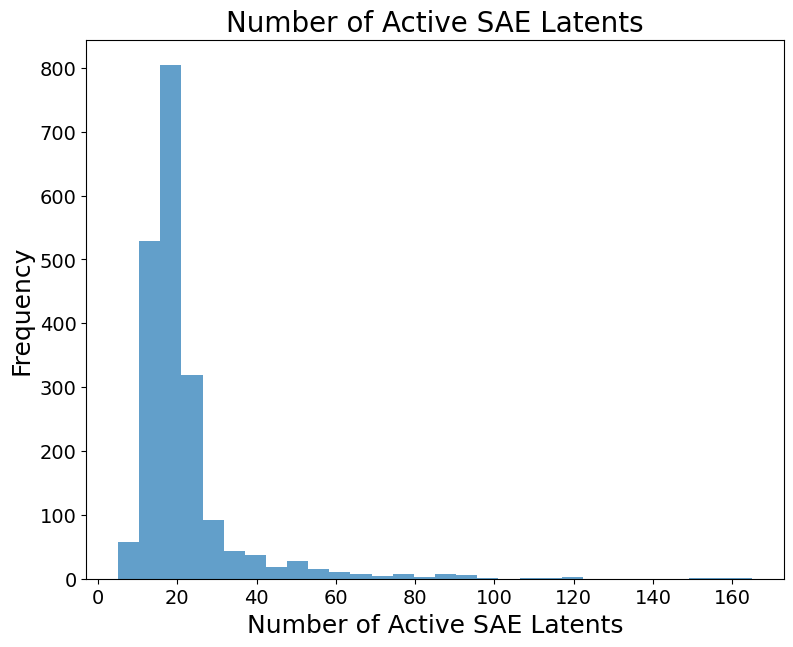

In [61]:
ticks_fontsize = 14
label_fontsize = 18
title_fontsize = 20
legend_fontsize = 14

plt.figure(figsize=(9, 7))  # width, height

plt.hist(
    num_active_features,
    bins=30,
    alpha=0.7,
    density=False,
)

title = "Number of Active SAE Latents"

plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)

# Customize the plot
plt.xlabel("Number of Active SAE Latents", fontsize=label_fontsize)
plt.ylabel("Frequency", fontsize=label_fontsize)
plt.title(title, fontsize=title_fontsize)

# Show the plot
plt.show()

### SAE Latent activation distribution per rank

In [17]:
top_k = 15
activations_per_rank = {i: [] for i in range(1, top_k + 1)}
percentages_per_rank = {i: [] for i in range(1, top_k + 1)}

for i, m in enumerate(metadata):
    steps = m["steps_metadata"]
    active_feature_ids = steps[0]["active_feature_ids"]
    active_feature_acts = steps[0]["active_feature_acts"]

    total_act = sum(active_feature_acts)

    sorted_acts, _ = torch.tensor(active_feature_acts).sort()
    sorted_acts = sorted_acts.flip(dims=(0,))[:top_k]
    ranks = range(len(active_feature_ids[:top_k]))

    for r, sa in zip(ranks, sorted_acts):
        activations_per_rank[r + 1].append(sa.item())
        percentages_per_rank[r + 1].append((sa.item() / total_act) * 100)

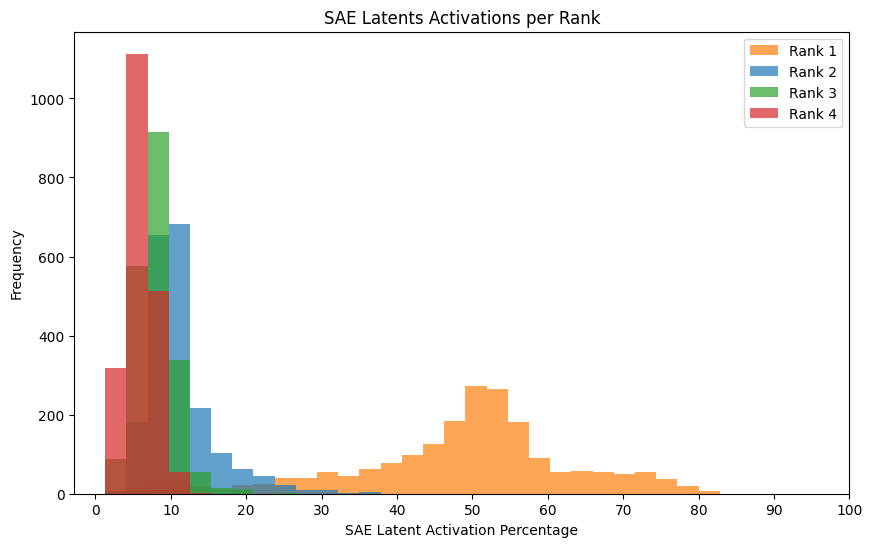

In [18]:
# Create the plot
plt.figure(figsize=(10, 6))

ranks_to_plot = [1, 2, 3, 4]

colors = {
    1: "tab:orange",
    2: "tab:blue",
    3: "tab:green",
    4: "tab:red",
    5: "tab:cyan",
    6: "tab:purple",
    7: "tab:pink",
    8: "tab:brown",
    9: "tab:gray",
    10: "tab:olive",
}


all_data = np.concatenate([percentages_per_rank[r] for r in ranks_to_plot])
bins = np.linspace(min(all_data), max(all_data), 30)

for r in ranks_to_plot:
    plt.hist(
        percentages_per_rank[r],
        bins=bins,
        alpha=0.7,
        label=f"Rank {r}",
        density=False,
        color=colors[r],
    )

plt.xticks(np.arange(0, 101, 10))

title = "SAE Latents Activations per Rank"

# Customize the plot
plt.xlabel("SAE Latent Activation Percentage")
plt.ylabel("Frequency")
plt.title(title)
plt.legend()

# Show the plot
plt.show()

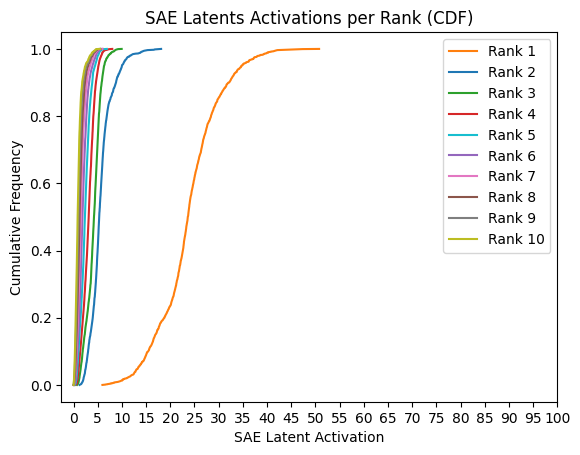

In [19]:
ranks_to_plot = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for r in ranks_to_plot:
    cdf = np.sort(activations_per_rank[r])
    plt.plot(
        cdf,
        np.linspace(0, 1, len(cdf)),
        label=f"Rank {r}",
        color=colors[r],
    )

plt.xticks(np.arange(0, 101, 5))

title = "SAE Latents Activations per Rank (CDF)"

# Customize the plot
plt.xlabel("SAE Latent Activation")
plt.ylabel("Cumulative Frequency")
plt.title(title)
plt.legend()

# Show the plot
plt.show()

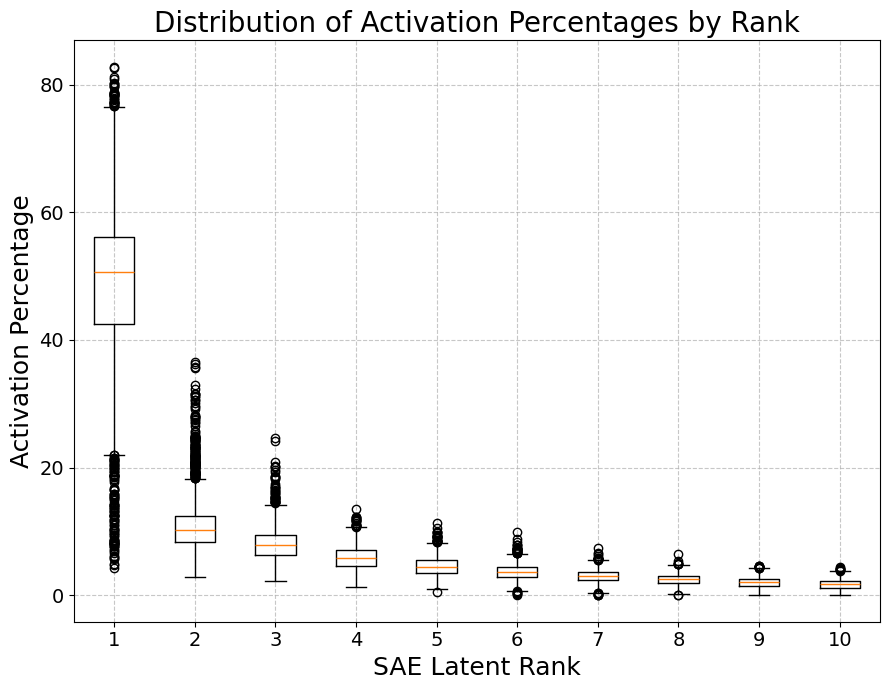

In [63]:
ticks_fontsize = 14
label_fontsize = 18
title_fontsize = 20
legend_fontsize = 14

# Sort the ranks to ensure they're in order on the x-axis
ranks = sorted(percentages_per_rank.keys())[:10]

# Create a list of activation lists, maintaining the rank order
data = [percentages_per_rank[rank] for rank in ranks]

# Create the box plot
plt.figure(figsize=(9, 7))  # width, height
plt.boxplot(data, tick_labels=ranks)

# Customize the plot
plt.title("Distribution of Activation Percentages by Rank", fontsize=title_fontsize)
plt.xlabel("SAE Latent Rank", fontsize=label_fontsize)
plt.ylabel("Activation Percentage", fontsize=label_fontsize)
plt.grid(True, linestyle="--", alpha=0.7)

plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)

# Show the plot
plt.tight_layout()
plt.show()

In [56]:
np.mean(percentages_per_rank[1])

48.867569948113115

### Synthetic activations

In [64]:
def synthetic_perturbation_homeschooled_v2(
    sae, active_feature_ids, active_feature_acts
):
    top_active_feature_id = active_feature_acts.argsort()[-1]
    mean_sim_base_target = 0.42

    spars_scores = abs(feature_sparsities - feature_sparsities[top_active_feature_id])
    spars_scores[top_active_feature_id] = torch.inf

    candidate_feat_ids = spars_scores.argsort()[:100]

    sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[candidate_feat_ids]
        )
        .detach()
        .cpu()
    )
    candidate_feat_id = candidate_feat_ids[
        abs(sims - mean_sim_base_target).argsort()[0]
    ]

    candidate_sims = (
        F.cosine_similarity(sae.W_dec[candidate_feat_id], sae.W_dec).detach().cpu()
    )
    top_feat_sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[active_feature_ids]
        )
        .detach()
        .cpu()
    )

    candidate_feature_ids = []
    candidate_feature_acts = []

    for i, f_id in enumerate(active_feature_ids):
        feat_cos_sim = top_feat_sims[i]
        feat_act = feature_acts[f_id]
        _, candidate_feat_ids = abs(candidate_sims - feat_cos_sim).sort()

        for cf_id in candidate_feat_ids:
            if cf_id in candidate_feature_ids:
                continue

            candidate_feature_ids.append(cf_id.item())
            candidate_feature_acts.append(feat_act.item())
            break

    return candidate_feature_ids, candidate_feature_acts

In [65]:
n_samples = 500

In [66]:
idxs = random.sample(range(len(metadata)), n_samples)

counter = 0

model_generated_active_feature_ids = []
model_generated_active_feature_acts = []

synth_active_feature_ids = []
synth_active_feature_acts = []

for idx in idxs:
    m = metadata[idx]
    acts = activations[idx]
    steps = m["steps_metadata"]
    prompt = torch.tensor(m["start_prompt"])
    start_act = torch.tensor(acts[0]).to(device)

    feature_acts = sae.encode(start_act.cpu()).detach()

    active_feature_ids = steps[0]["active_feature_ids"]
    active_feature_acts = steps[0]["active_feature_acts"]

    model_generated_active_feature_ids.append(active_feature_ids)
    model_generated_active_feature_acts.append(active_feature_acts)

    candidate_feature_ids, candidate_feature_acts = (
        synthetic_perturbation_homeschooled_v2(
            sae, torch.tensor(active_feature_ids), torch.tensor(active_feature_acts)
        )
    )

    synth_active_feature_ids.append(candidate_feature_ids)
    synth_active_feature_acts.append(candidate_feature_acts)

    counter += 1

    if counter % 50 == 0:
        print(f"Processed {counter}/{len(idxs)}")

Processed 50/500
Processed 100/500
Processed 150/500
Processed 200/500
Processed 250/500
Processed 300/500
Processed 350/500
Processed 400/500
Processed 450/500
Processed 500/500


In [105]:
model_generated_cos_sims = []
synth_cos_sims = []

for i in range(n_samples):
    # Model generated
    active_feature_ids = model_generated_active_feature_ids[i]
    active_feature_acts = model_generated_active_feature_acts[i]

    sorted_acts, sorted_idxs = torch.tensor(active_feature_acts).sort()
    sorted_feature_ids = torch.tensor(active_feature_ids)[sorted_idxs]

    top_feature_id = sorted_feature_ids[-1]
    rest_feature_ids = sorted_feature_ids[:-1]

    sims = F.cosine_similarity(
        sae.W_dec[top_feature_id], sae.W_dec[rest_feature_ids]
    ).detach()
    model_generated_cos_sims.extend(sims.tolist())

    # Synths
    active_feature_ids = synth_active_feature_ids[i]
    active_feature_acts = synth_active_feature_acts[i]

    sorted_acts, sorted_idxs = torch.tensor(active_feature_acts).sort()
    sorted_feature_ids = torch.tensor(active_feature_ids)[sorted_idxs]

    top_feature_id = sorted_feature_ids[-1]
    rest_feature_ids = sorted_feature_ids[:-1]

    sims = F.cosine_similarity(
        sae.W_dec[top_feature_id], sae.W_dec[rest_feature_ids]
    ).detach()
    synth_cos_sims.extend(sims.tolist())

In [115]:
np.array(model_generated_cos_sims).mean()

0.18011059584004946

In [107]:
np.array(synth_cos_sims).mean()

0.031208307975751946

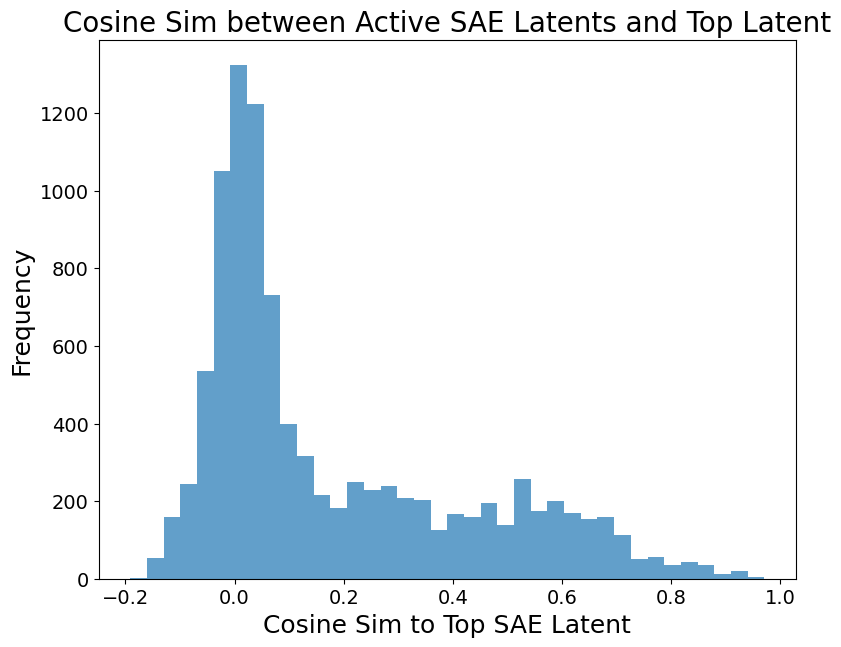

In [108]:
ticks_fontsize = 14
label_fontsize = 18
title_fontsize = 20
legend_fontsize = 14

# Create the box plot
plt.figure(figsize=(9, 7))  # width, height

# all_data = np.concatenate([model_generated_cos_sims, synth_cos_sims])
# bins = np.linspace(min(all_data), max(all_data), 30)

plt.hist(
    model_generated_cos_sims,
    bins="auto",
    alpha=0.7,
    density=False,
    color="tab:blue",
    label="Model Generated",
)
# plt.hist(synth_cos_sims, bins=bins, alpha=0.7, density=False, color="tab:green", label="Synthetic Structured")

plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)

title = "Cosine Sim between Active SAE Latents and Top Latent"

# Customize the plot
plt.xlabel("Cosine Sim to Top SAE Latent", fontsize=label_fontsize)
plt.ylabel("Frequency", fontsize=label_fontsize)
plt.title(title, fontsize=title_fontsize)
# plt.legend()

# Show the plot
plt.show()

In [111]:
def compute_all_cosine_similarities(sae, active_feature_ids):
    active_weights = sae.W_dec[active_feature_ids]
    n = active_weights.size(0)
    normalized_weights = F.normalize(active_weights, p=2, dim=1)
    similarity_matrix = torch.mm(normalized_weights, normalized_weights.t())
    mask = torch.eye(n, device=similarity_matrix.device)
    similarity_matrix = similarity_matrix * (1 - mask)
    upper_triangular = torch.triu(similarity_matrix, diagonal=1)
    sims = upper_triangular[upper_triangular != 0]
    return sims


def compute_mean_cosine_similarity(sae, list_of_active_feature_ids):
    all_sims = []
    for active_feature_ids in list_of_active_feature_ids:
        sims = compute_all_cosine_similarities(sae, active_feature_ids)
        all_sims.extend(sims.tolist())

    mean_similarity = torch.tensor(all_sims).mean().item()
    return mean_similarity, all_sims

In [112]:
sims = compute_all_cosine_similarities(sae, active_feature_ids)

In [113]:
mean_cossim, all_sims = compute_mean_cosine_similarity(
    sae, model_generated_active_feature_ids
)

In [114]:
mean_cossim

0.2865789830684662

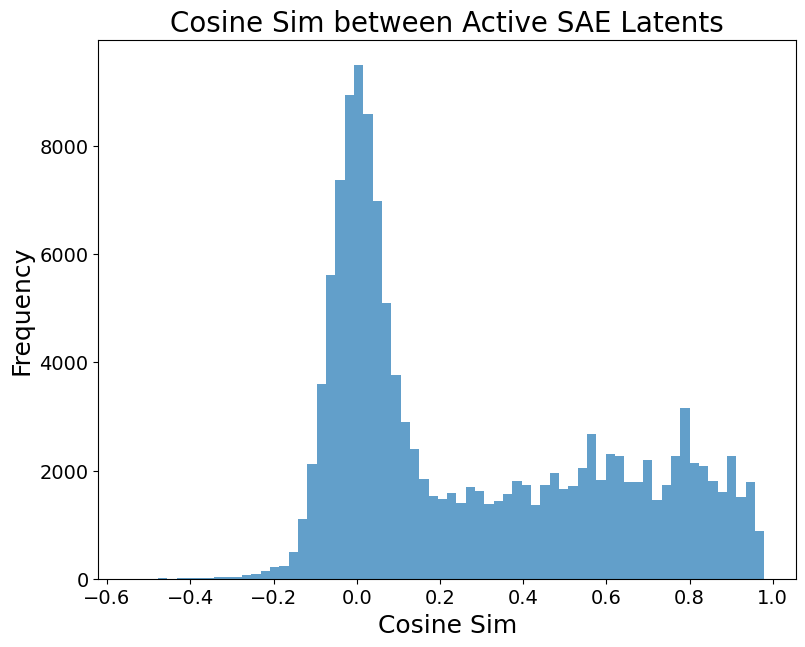

In [109]:
ticks_fontsize = 14
label_fontsize = 18
title_fontsize = 20
legend_fontsize = 14

# Create the box plot
plt.figure(figsize=(9, 7))  # width, height

plt.hist(
    all_sims,
    bins="auto",
    alpha=0.7,
    density=False,
    color="tab:blue",
    label="Model Generated",
)

plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)

title = "Cosine Sim between Active SAE Latents"

# Customize the plot
plt.xlabel("Cosine Sim", fontsize=label_fontsize)
plt.ylabel("Frequency", fontsize=label_fontsize)
plt.title(title, fontsize=title_fontsize)
# plt.legend()

# Show the plot
plt.show()

### Pairwise cos sims with top SAE latent (histogram)

In [209]:
cos_sims = []

for i, m in enumerate(metadata):
    steps = m["steps_metadata"]
    active_feature_ids = steps[0]["active_feature_ids"]
    active_feature_acts = steps[0]["active_feature_acts"]

    sorted_acts, sorted_idxs = torch.tensor(active_feature_acts).sort()
    sorted_feature_ids = torch.tensor(active_feature_ids)[sorted_idxs]

    top_feature_id = sorted_feature_ids[-1]
    rest_feature_ids = sorted_feature_ids[:-1]

    sims = F.cosine_similarity(
        sae.W_dec[top_feature_id], sae.W_dec[rest_feature_ids]
    ).detach()
    cos_sims.extend(sims.tolist())

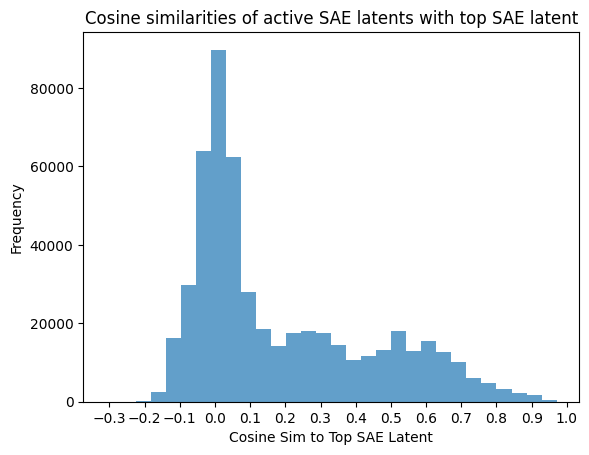

In [224]:
plt.hist(cos_sims, bins=30, alpha=0.7, density=False, color="tab:blue")

plt.xticks(np.arange(-0.3, 1.1, 0.1))

title = "Cosine similarities of active SAE latents with top SAE latent"

# Customize the plot
plt.xlabel("Cosine Sim to Top SAE Latent")
plt.ylabel("Frequency")
plt.title(title)

# Show the plot
plt.show()

### Scatter plot of SAE Latent Sparsities and mean activations

In [220]:
activations_per_sparsity = {}

for i, m in enumerate(metadata):
    steps = m["steps_metadata"]
    active_feature_ids = steps[0]["active_feature_ids"]
    active_feature_acts = steps[0]["active_feature_acts"]

    total_act = sum(active_feature_acts)

    for f_id, act in zip(active_feature_ids, active_feature_acts):
        spars = feature_sparsities[f_id].item()
        if activations_per_sparsity.get(spars) is None:
            activations_per_sparsity[spars] = []

        activations_per_sparsity[spars].append((act / total_act) * 100)

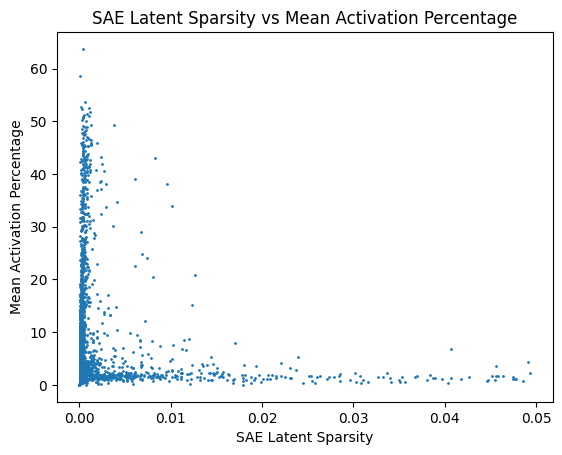

In [232]:
for s, a in activations_per_sparsity.items():
    if s > 0.05:
        continue
    ma = np.mean(a)
    plt.scatter(s, ma, color="tab:blue", s=1)


title = "SAE Latent Sparsity vs Mean Activation Percentage"

# Customize the plot
plt.xlabel("SAE Latent Sparsity")
plt.ylabel("Mean Activation Percentage")
plt.title(title)

# Show the plot
plt.show()

### Exploring activation plateaus

In [7]:
import pickle
import random

is_absolute_step_size = True
n_samples = 1000

suffix = "absolute" if is_absolute_step_size else "relative"
filename = f"replications/activation_plateaus_{n_samples}_{suffix}.pkl"

# # # Save results
# with open(filename, "wb") as fw:
#     pickle.dump(results, fw)

# Load results
with open(filename, "rb") as fr:
    results = pickle.load(fr)

In [27]:
results["l2"].keys()

dict_keys(['synthetic', 'other', 'random', 'recon_other', 'bag_of_features', 'single_feature'])

In [85]:
sample_idxs = random.sample(range(n_samples), 10)

name = "other"

sample_l2_other = [results["l2"][name][i] for i in sample_idxs]
sample_ap_other = [results["l2_ap"][name][i] for i in sample_idxs]

name = "synthetic"

sample_l2_synth = [results["l2"][name][i] for i in sample_idxs]
sample_ap_synth = [results["l2_ap"][name][i] for i in sample_idxs]

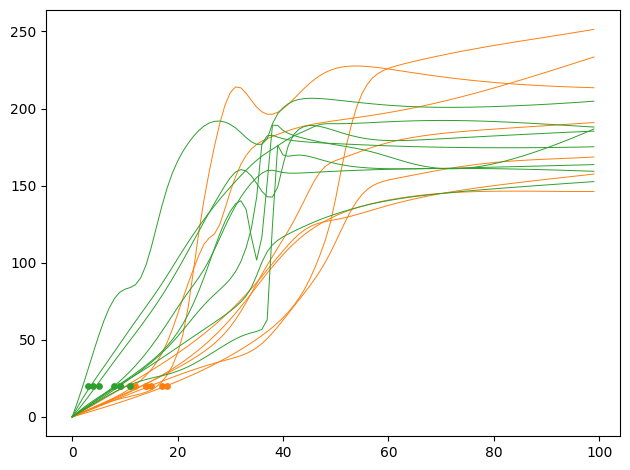

In [86]:
for i, s in enumerate(sample_l2_other):
    if max(s) > 300:
        continue
    plt.plot(s, color="tab:orange", linewidth=0.7)
    plt.scatter(
        sample_ap_other[i],
        20,
        color="tab:orange",
        s=15,
        zorder=3,
        marker="o",
    )

for i, s in enumerate(sample_l2_synth):
    if max(s) > 300:
        continue
    plt.plot(s, color="tab:green", linewidth=0.7)
    plt.scatter(
        sample_ap_synth[i],
        20,
        color="tab:green",
        s=15,
        zorder=3,
        marker="o",
    )

plt.tight_layout()
plt.show()